<img src="https://pngimage.net/wp-content/uploads/2018/06/lisboa-png-3.png" align="center" width="500"/>

<h1 align="center"> Segmentation and Clustering Parishes in Lisbon(POR)</h1>

### __Summary__

In this notebook, we will explore, segment, and cluster the parishes in the city of Lisbon. When you hear of Europe's hot destinations, Portugal is surely at the top of the charts. At the center of this beautiful country you find its capital, Lisbon. The world is full of wonderful and exciting cities to visit, and Lisbon is one that should be on everyone’s bucket list. It has everything within easy reach, from galleries and museums to the seaside and charming nearby villages. Lisbon is also extremely budget-friendly, making it easy to navigate and explore in depth. 

Soon I will be leaving my hometown, Braga, in the north of Portugal to start my adult life in Lisbon, working on 9 to 6 job. I am that kind of person that needs to go out and socialize on a daily basis, in order to maintain its sanity. This is where we have a problem... I know nothing about Lisbon's hot spots, due to only have visited the city three times. As such, I am "combining business with pleasure": IBM's data science capstone project with the urge to know more about Lisbon's most cultural and coolest parishes. 

This project aims to nullify these urges by segmenting and clustering Lisbon's major metropolitan area, in terms of social and cultural venues. With this in mind, I will gather data by the means of web scraping and Foursquare's API. 

This endeavour will mostly be useful to myself, but it would be very rewarding if by any chance (close to none), common people like myself could make use of this data and get a bigger picture about what Lisbon has to offer and where to find it. 

The first step is acquiring Lisbon's metropolitan area parishes names and its geographical coordinates. To solve this need we will have to perform web scraping and make use of Foursquare's API.

#### __Data gathering__

__1.__ The website from where the parishes names were collected using BeaufifulSoup library (<a href="https://beautiful-soup-4.readthedocs.io/en/latest/">BeautifulSoup Documentation</a>),

- https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa

__2.__ Fetch the coordinates for the given parishes, using Geolocator from the GeoPY library.

__3.__ Create a dataframe that includes all of the information gathered so far. Obviously, the dataframe is then properly cleaned, removing any value that does not suite our needs, such as invalid/wrong parishes names and coordinates.

__4.__ Utilize the Foursquare's API to query about the venues of each one of Lisbon's parishes. This includes, the type of venue (or category) and it's name.

We will then analyze the data gathered to find out the most common venues per neighborhood using one hot encoding and utilize the proper visualization techniques to take some conclusions has we move further is this project. 

Lastly, we will try to cluster the parishes based on the venue categories and use K-means clustering. To find the best value for the number of clusters, we will use the elbow method, therefore guaranteeing the best possible clustering outcome. In sum, our expectations is that based on the existing or non-existing similarities between parishes, we will be able to divide them into several different clusters. 

### __Importing Libraries__

In [1]:
# library for data analsysis
import pandas as pd
# library to handle data in a vectorized manner
import numpy as np
# library to handle requests
import requests
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# csv handler
import csv
# matplotlib for plotting
import matplotlib.pyplot as plt

# import BeuatifulSoup library
from bs4 import BeautifulSoup

# map rendering library
!pip install folium
import folium

# geocoding library
!pip install geopy
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim

### __Data Gathering__

### Scrape the Lisbon's data from the <a href="https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa"> Wikipedia page</a> using BeautifulSoup

In [51]:
# link of the wikipedia page containing the needed table
source = requests.get('https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa').text
soup= BeautifulSoup(source,'lxml')
# If you want to see the source code
#print(soup.prettify())

df=pd.read_html(source) 
df=df[0]
df.head()

Freguesias atuais                                                \
        N.º[nota 1]    Brasão    Freguesia (Zona)[1] População[4]   
0                 1       NaN      Ajuda (Ocidental)       15 617   
1                 2       NaN  Alcântara (Ocidental)       13 943   
2                54  [nota 6]      Alvalade (Centro)       31 813   
3                54  [nota 6]      Alvalade (Centro)       31 813   
4                54  [nota 6]      Alvalade (Centro)       31 813   

                Freguesias antigas         \
   Área(km²)[3]        N.º[nota 2] Brasão   
0           288                  1    NaN   
1  5,07[nota 4]                  2    NaN   
2           534                  4    NaN   
3           534                  9    NaN   
4           534                 42    NaN   

                                                                           
                       Freguesia (Bairro) População(2011)[6] Área(km²)[5]  
0              Ajuda[nota 3] (2.º Bairro)             15 584          286  
1          Alcântara[nota 5] (2.º Bairro)             13 943          444  
2           Alvalade[nota 7] (3.º Bairro)              8 869           60  
3       Campo Grande[nota 8] (3.º Bairro)             10 514          245  
4  São João de Brito[nota 9] (3.º Bairro)             11 727          223

#### __Data pre-processing__

In [3]:
df.columns

MultiIndex(levels=[['Freguesias antigas', 'Freguesias atuais'], ['Brasão', 'Freguesia (Bairro)', 'Freguesia (Zona)[1]', 'N.º[nota 1]', 'N.º[nota 2]', 'População(2011)[6]', 'População[4]', 'Área(km²)[3]', 'Área(km²)[5]']],
           codes=[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [3, 0, 2, 6, 7, 4, 0, 1, 5, 8]])

In [4]:
df.columns = [col[1] for col in df.columns]
df.head()

,N.º[nota 1],Brasão,Freguesia (Zona)[1],População[4],Área(km²)[3],N.º[nota 2],Brasão,Freguesia (Bairro),População(2011)[6],Área(km²)[5]
0,1,NaN,Ajuda (Ocidental),15 617,288,1,NaN,Ajuda[nota 3] (2.º Bairro),15 584,286
1,2,NaN,Alcântara (Ocidental),13 943,"5,07[nota 4]",2,NaN,Alcântara[nota 5] (2.º Bairro),13 943,444
2,54,[nota 6],Alvalade (Centro),31 813,534,4,NaN,Alvalade[nota 7] (3.º Bairro),8 869,60
3,54,[nota 6],Alvalade (Centro),31 813,534,9,NaN,Campo Grande[nota 8] (3.º Bairro),10 514,245
4,54,[nota 6],Alvalade (Centro),31 813,534,42,NaN,São João de Brito[nota 9] (3.º Bairro),11 727,223


In [5]:
lisbon=df.drop(['N.º[nota 1]','Brasão','N.º[nota 2]', 'População(2011)[6]', 'Área(km²)[5]','Freguesia (Bairro)'],axis=1)

In [6]:
lisbon.head()

,Freguesia (Zona)[1],População[4],Área(km²)[3]
0,Ajuda (Ocidental),15 617,288
1,Alcântara (Ocidental),13 943,"5,07[nota 4]"
2,Alvalade (Centro),31 813,534
3,Alvalade (Centro),31 813,534
4,Alvalade (Centro),31 813,534


In [7]:
lisbon=lisbon.rename(columns={'Freguesia (Zona)[1]':'Parish','População[4]':'Population','Área(km²)[3]':'Area'})
lisbon[:15]

,Parish,Population,Area
0,Ajuda (Ocidental),15 617,288
1,Alcântara (Ocidental),13 943,"5,07[nota 4]"
2,Alvalade (Centro),31 813,534
3,Alvalade (Centro),31 813,534
4,Alvalade (Centro),31 813,534
5,Areeiro (Centro),20 131,174
6,Areeiro (Centro),20 131,174
7,Arroios (Centro),31 653,213
8,Arroios (Centro),31 653,213
9,Arroios (Centro),31 653,213


We have filtered the unwanted features from the scrapped data. But it is noticeable that several boroughs are duplicated and some of the data is associated with a given note, "[nota x]". Hence, it is important to remove these unwanted values from our dataframe.



First we drop the duplicated parishes, keeping only the first appearance of a given parish

In [8]:
# dropping ALL duplicte values 
lisbon.drop_duplicates(subset ="Parish", 
                     keep = 'first', inplace = True) 
lisbon

,Parish,Population,Area
0,Ajuda (Ocidental),15 617,288
1,Alcântara (Ocidental),13 943,"5,07[nota 4]"
2,Alvalade (Centro),31 813,534
5,Areeiro (Centro),20 131,174
7,Arroios (Centro),31 653,213
10,Avenidas Novas (Centro),21 625,299
12,Beato (Oriental),12 737,"2,46[nota 4]"
13,Belém (Ocidental),16 528,"10,43[nota 17]"
15,Benfica (Norte),36 985,803
16,Campo de Ourique (Centro Historico),22 120,165


Created a function capable of removing the annoying "[nota x]" in "Parish" and "Area" columns.

In [9]:
# Importing re package for using regular expressions 
import re 
  
# Function to clean the names 
def clean_area(area): 
    # Search for opening bracket in the name followed by 
    # any characters repeated any number of times 
        if re.search(x, area): 
  
        # Extract the position of beginning of pattern 
            pos = re.search(x, area).start() 
  
        # return the cleaned name 
            return area[:pos] 
  
        else: 
        # if clean up needed return the same name 
            return area

In [10]:
# Updated the columns 
char=["\(","\["]
for x in char:
    #print(x)
    lisbon['Area'] = lisbon['Area'].apply(clean_area)  
    lisbon['Parish'] = lisbon['Parish'].apply(clean_area)

In [11]:
lisbon.reset_index(inplace=True,drop=True)

In [50]:
lisbon

,Parish,Population,Area,Latitude,Longitude
0,Ajuda,15 617,288,38.711730,-9.201170
1,Alcântara,13 943,"5,07",38.704570,-9.176230
2,Alvalade,31 813,534,38.751780,-9.143260
3,Areeiro,20 131,174,38.745940,-9.134590
4,Arroios,31 653,213,38.734560,-9.134100
5,Avenidas Novas,21 625,299,38.738889,-9.145833
6,Beato,12 737,"2,46",38.733930,-9.105390
7,Belém,16 528,"10,43",38.697120,-9.205370
8,Benfica,36 985,803,38.751100,-9.197400
9,Campo de Ourique,22 120,165,38.719130,-9.169610


### Fetch the parishe's coordinates using geocoder

In [12]:
length=lisbon['Parish'].shape[0]
parish=lisbon['Parish'].reset_index(drop=True)
lat = []
long = []

latitude = np.array(lat, dtype = np.float32)
longitude = np.array(long, dtype = np.float32)

for i in range (0,length):
    #print('cell',i)
    lat_long=None
    
    while(lat_long is None):
            g = geocoder.arcgis('{},Lisbon,Portugal'.format(parish[i]))
            
            lat_long = g.latlng
            #print(lat_long)
            
            
            latitude=np.append(latitude,lat_long[0])
            longitude=np.append(longitude,lat_long[1])

Ensure that the coordinates have the same size

In [13]:
# just checking if they match
latitude.shape

(24,)

In [14]:
# just checking if they match
longitude.shape

(24,)

In [15]:
lisbon['Latitude']=latitude
lisbon['Longitude']=longitude

Fecth coordinates of Lisbon

In [16]:
g = geocoder.arcgis('Lisbon,Portugal')
            
ll_lisbon = g.latlng
print(ll_lisbon)
            
lat_lisb = ll_lisbon[0]
long_lisb = ll_lisbon[1]

[38.72639000000004, -9.149479999999926]


In [53]:
lisbon.head()

,Parish,Population,Area,Latitude,Longitude
0,Ajuda,15 617,288,38.71173,-9.20117
1,Alcântara,13 943,"5,07",38.70457,-9.17623
2,Alvalade,31 813,534,38.75178,-9.14326
3,Areeiro,20 131,174,38.74594,-9.13459
4,Arroios,31 653,213,38.73456,-9.13410


### First map creation of the city of Lisbon

In [17]:
# create map of New York using latitude and longitude values
map_lisbon = folium.Map(location=[lat_lisb, long_lisb], zoom_start=10)

# add markers to map
for lat, lng, parish, area, pop in zip(lisbon['Latitude'], lisbon['Longitude'], lisbon['Parish'],lisbon['Area'],lisbon['Population']):
    label = '{}, {}, {}'.format(parish, area, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

### Changing faultly parish's coordinates (Santo António, Misericórdia, Avenidas Novas, Santa Clara, São Vicente and Santa Maria Maior)

As one can observe in the map depicted above, some of the parishes seem to not belong to Lisbon's metropolitan area. One quick search away and I find that the coordinates of these parishes were wrongly acquired. I have decided to insert them in the dataframe "manually" instead of scraping the information from the web, for one reason only, there were only 5 parishe's coordinates wrongly obtained. 

__This were the coordinates obtained__

(38.738889, -9.145833) -> Avenidas novas - https://pt.wikipedia.org/wiki/Avenidas_Novas

(38.719444, -9.126389) -> São Vicente - https://pt.wikipedia.org/wiki/S%C3%A3o_Vicente_(Lisboa)

(38.724167, -9.145) -> Santo António - https://pt.wikipedia.org/wiki/Santo_Ant%C3%B3nio_(Lisboa)

(38.711389, -9.148056) -> Misericórdia - https://pt.wikipedia.org/wiki/Miseric%C3%B3rdia_(Lisboa)

(38.785278, -9.145) -> Santa Clara - https://pt.wikipedia.org/wiki/Santa_Clara_(Lisboa)

Now we will insert them in the dataframe 

In [18]:
#function to replace the coordinates

def chang_coord(par,x,y):
    i=0
    while i < len(par): 
        #if par != par - 1:
            lisbon.loc[par[i],['Latitude']] = x[i]
            print(lisbon.loc[par,['Latitude']])
            print("i",i)
            lisbon.loc[par[i],['Longitude']] = y[i] 
            print(lisbon.loc[par,['Longitude']])
            print("iteration:",i)
            print("parish",par[i])
            i=i+1

In [19]:
# parishes IDs
parish=[5, 19, 23, 21, 15, 20]
# coordenates for Avs. Novas, S. Clara, S. Vicente, S. António, Misericórdia, Santa Maria Maior
x = np.array([38.738889, 38.785278, 38.719444, 38.724167, 38.711389, 38.712778])
y = np.array([-9.145833, -9.145, -9.126389, -9.145, -9.148056, -9.135556])
#for par in parish:
chang_coord(parish,x,y)

     Latitude
5   38.738889
19  38.817330
23  39.074426
21  39.043130
15  38.965345
20  32.633330
i 0
    Longitude
5   -9.145833
19  -9.222403
23  -9.223056
21  -9.000340
15  -9.417621
20 -16.883330
iteration: 0
parish 5
     Latitude
5   38.738889
19  38.785278
23  39.074426
21  39.043130
15  38.965345
20  32.633330
i 1
    Longitude
5   -9.145833
19  -9.145000
23  -9.223056
21  -9.000340
15  -9.417621
20 -16.883330
iteration: 1
parish 19
     Latitude
5   38.738889
19  38.785278
23  38.719444
21  39.043130
15  38.965345
20  32.633330
i 2
    Longitude
5   -9.145833
19  -9.145000
23  -9.126389
21  -9.000340
15  -9.417621
20 -16.883330
iteration: 2
parish 23
     Latitude
5   38.738889
19  38.785278
23  38.719444
21  38.724167
15  38.965345
20  32.633330
i 3
    Longitude
5   -9.145833
19  -9.145000
23  -9.126389
21  -9.145000
15  -9.417621
20 -16.883330
iteration: 3
parish 21
     Latitude
5   38.738889
19  38.785278
23  38.719444
21  38.724167
15  38.711389
20  32.633330
i 4
    Lon

#### Check if everything was done properly

In [20]:
lisbon

,Parish,Population,Area,Latitude,Longitude
0,Ajuda,15 617,288,38.711730,-9.201170
1,Alcântara,13 943,"5,07",38.704570,-9.176230
2,Alvalade,31 813,534,38.751780,-9.143260
3,Areeiro,20 131,174,38.745940,-9.134590
4,Arroios,31 653,213,38.734560,-9.134100
5,Avenidas Novas,21 625,299,38.738889,-9.145833
6,Beato,12 737,"2,46",38.733930,-9.105390
7,Belém,16 528,"10,43",38.697120,-9.205370
8,Benfica,36 985,803,38.751100,-9.197400
9,Campo de Ourique,22 120,165,38.719130,-9.169610


In [21]:

#parish = lisbon.Parish
#index = np.arange(len(parish))
#y_pos = np.arange(len(parish))

#population = lisbon.loc[:,"Population"]

#plt.bar(index, population)
#plt.xticks(index,parish, rotation='vertical')
#plt.ylabel('Population')
#plt.title('Population in Lisbon\'s Parishes')
#plt.show()


#### Second map visualization using Folium library

Everything is done as it should be now

In [22]:
# create map of New York using latitude and longitude values
map_lisbon = folium.Map(location=[lat_lisb, long_lisb], zoom_start=10)

# add markers to map
for lat, lng, parish, area, pop in zip(lisbon['Latitude'], lisbon['Longitude'], lisbon['Parish'],lisbon['Area'],lisbon['Population']):
    label = '{}, {}, {}'.format(parish, area, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

### Using Foursquare API to fetch the venues information in the city of Lisbon

In [23]:
CLIENT_ID = 'Y13NNMPP52FI1IBFHIVAG2YIXMVXSKYJLUSJALPPJKMXLL0V' # your Foursquare ID
CLIENT_SECRET = 'L1Y15FVS0F2OZYDUIZU0AGVMUW3GBRNNE4RPKCGCYXLSJLND' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y13NNMPP52FI1IBFHIVAG2YIXMVXSKYJLUSJALPPJKMXLL0V
CLIENT_SECRET:L1Y15FVS0F2OZYDUIZU0AGVMUW3GBRNNE4RPKCGCYXLSJLND


In [24]:
def getNeighborhoods(names,lats,longs):
    
    l = []
    venues_list = []
    for name,lat,lng in zip(names,lats,longs):
        #debugg
        #print(name)
        
        # initialize the needed variables
        LIMIT=100
        radius=1000

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                lat,
                lng,
                radius,
                LIMIT)
        
        results2 = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # get the relevant information for each venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results2])
        
    for venue_list in venues_list:
        #print(venue_list)
        for item in venue_list:
            #print(item)
            l.append(item)
                
    venues_list = pd.DataFrame(l)        
    
    return(venues_list)

In [25]:
lisbon_venues = getNeighborhoods(names = lisbon['Parish'],
                                   lats = lisbon['Latitude'],
                                   longs = lisbon['Longitude']
                                  )

In [26]:
print(lisbon_venues.shape)
lisbon_venues.head()

(1910, 7)


,0,1,2,3,4,5,6
0,Ajuda,38.71173,-9.20117,Mercado do Peixe,38.712692,-9.203276,Seafood Restaurant
1,Ajuda,38.71173,-9.20117,Palácio Nacional da Ajuda,38.707653,-9.197758,Historic Site
2,Ajuda,38.71173,-9.20117,Montes Claros,38.717541,-9.201562,Restaurant
3,Ajuda,38.71173,-9.20117,Páteo Alfacinha,38.706537,-9.194202,Restaurant
4,Ajuda,38.71173,-9.20117,Jardim Botânico da Ajuda,38.706430,-9.201222,Botanical Garden


In [49]:
lisbon_venues.shape

(1910, 7)

In [54]:
lisbon_venues.columns = ['Parish','Parish Latitude','Parish Longitude','Venue Name','Venue Latitude','Venue Longitude','Venue Category']
lisbon_venues.head()

,Parish,Parish Latitude,Parish Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,38.71173,-9.20117,Mercado do Peixe,38.712692,-9.203276,Seafood Restaurant
1,Ajuda,38.71173,-9.20117,Palácio Nacional da Ajuda,38.707653,-9.197758,Historic Site
2,Ajuda,38.71173,-9.20117,Montes Claros,38.717541,-9.201562,Restaurant
3,Ajuda,38.71173,-9.20117,Páteo Alfacinha,38.706537,-9.194202,Restaurant
4,Ajuda,38.71173,-9.20117,Jardim Botânico da Ajuda,38.706430,-9.201222,Botanical Garden


In [28]:
print('There are {} unique categories'.format(len(lisbon_venues['Venue Category'].unique())))

There are 212 unique categories


How many venues are there per parish?

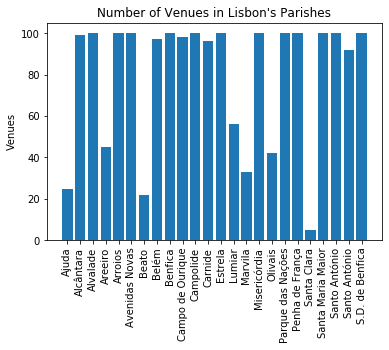

In [86]:
lisbon2=lisbon_venues.groupby('Parish').count()
Names= ["Ajuda",'Alcântara','Alvalade','Areeiro','Arroios','Avenidas Novas','Beato','Belém'
       ,'Benfica','Campo de Ourique','Campolide','Carnide',
       'Estrela','Lumiar','Marvila','Misericórdia','Olivais','Parque das Nações'
       ,'Penha de França','Santa Clara','Santa Maria Maior',
       'Santo António','Santo António','S.D. de Benfica','São Vicente']

index = np.arange(len(Names)-1)
#y_pos = np.arange(len(parish))

population = lisbon2.loc[:,"Venue Name"]

plt.bar(index,population)
plt.xticks(index,Names, rotation='vertical')
plt.ylabel('Venues')
plt.title('Number of Venues in Lisbon\'s Parishes')
plt.show()


In [87]:
lisbon2

,Parish Latitude,Parish Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Parish,,,,,,
Ajuda,25,25,25,25,25,25
Alcântara,99,99,99,99,99,99
Alvalade,100,100,100,100,100,100
Areeiro,45,45,45,45,45,45
Arroios,100,100,100,100,100,100
Avenidas Novas,100,100,100,100,100,100
Beato,22,22,22,22,22,22
Belém,97,97,97,97,97,97
Benfica,100,100,100,100,100,100


Highest number of venue category in Lisbon's parishes

In [30]:
# get the number of appearances for each venue category (best method)
venues_freq=lisbon_venues.groupby('Venue Category').size().sort_values(ascending=False)
venues_freq

Venue Category
Portuguese Restaurant            223
Restaurant                       116
Café                             114
Hotel                             83
Bakery                            74
Coffee Shop                       48
Ice Cream Shop                    44
Italian Restaurant                41
Bar                               41
Burger Joint                      39
Seafood Restaurant                36
Plaza                             33
Indian Restaurant                 32
Supermarket                       31
Pizza Place                       30
Garden                            28
Scenic Lookout                    25
Vegetarian / Vegan Restaurant     25
Sushi Restaurant                  23
Steakhouse                        21
Mediterranean Restaurant          21
Park                              21
Gym / Fitness Center              21
Gym                               20
Electronics Store                 20
Hostel                            19
Chinese Restaurant     

#### One hot encoding 

In [31]:
# One hot encoding
lisbon_hot = pd.get_dummies(lisbon_venues[['Venue Category']], prefix="",prefix_sep="")

# insert the column neighborhood in the first position
ngh=lisbon_venues['Parish']
lisbon_hot.insert(0,'Parish',ngh)

In [32]:
lisbon_hot = lisbon_hot.groupby('Parish').mean().reset_index()
lisbon_hot

,Parish,Accessories Store,Adult Boutique,Amphitheater,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Ajuda,0.00,0.00000,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.00,0.00000
1,Alcântara,0.00,0.00000,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010101,0.00,0.00,0.00000,0.00,0.00000
2,Alvalade,0.00,0.00000,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.020000,...,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.00,0.00000,0.00,0.00000
3,Areeiro,0.00,0.00000,0.00,0.00,0.000000,0.022222,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.00,0.00000
4,Arroios,0.00,0.00000,0.00,0.00,0.010000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.030000,0.000000,0.00,0.01,0.00000,0.01,0.00000
5,Avenidas Novas,0.00,0.00000,0.00,0.00,0.000000,0.010000,0.020000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.050000,0.000000,0.00,0.00,0.00000,0.00,0.00000
6,Beato,0.00,0.00000,0.00,0.00,0.045455,0.000000,0.000000,0.00000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.00,0.00000
7,Belém,0.00,0.00000,0.00,0.00,0.000000,0.000000,0.020619,0.00000,0.000000,...,0.000000,0.000000,0.010309,0.000000,0.000000,0.00,0.00,0.00000,0.00,0.00000
8,Benfica,0.00,0.00000,0.00,0.00,0.010000,0.000000,0.000000,0.00000,0.010000,...,0.000000,0.020000,0.010000,0.020000,0.000000,0.00,0.00,0.00000,0.00,0.00000
9,Campo de Ourique,0.00,0.00000,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.00,0.00000


In [33]:
num_top_venues = 5

for hood in lisbon_hot['Parish']:
    print("----"+hood+"----")
    temp = lisbon_hot[lisbon_hot['Parish'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ajuda ----
              venue  freq
0        Restaurant  0.16
1       Supermarket  0.08
2       Coffee Shop  0.04
3  Botanical Garden  0.04
4               Gym  0.04


----Alcântara ----
                   venue  freq
0             Restaurant  0.11
1  Portuguese Restaurant  0.09
2                   Café  0.04
3            Coffee Shop  0.04
4                 Bakery  0.04


----Alvalade ----
                   venue  freq
0  Portuguese Restaurant  0.17
1             Restaurant  0.09
2                    Bar  0.07
3                 Bakery  0.06
4     Italian Restaurant  0.04


----Areeiro ----
                   venue  freq
0  Portuguese Restaurant  0.18
1         Ice Cream Shop  0.07
2                    Bar  0.07
3            Pizza Place  0.04
4           Burger Joint  0.04


----Arroios ----
                   venue  freq
0  Portuguese Restaurant  0.10
1                  Hotel  0.09
2                 Bakery  0.06
3      Electronics Store  0.04
4                   Café  0.04


----

#### Function to acquire the top 5 venues for the different parishes

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [153]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Parish']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Parish'] = lisbon_hot['Parish']

for ind in np.arange(lisbon_hot.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lisbon_hot.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,Restaurant,Supermarket,Tennis Court,Scenic Lookout,Café,Soccer Field,Botanical Garden,Chinese Restaurant,Church,Portuguese Restaurant
1,Alcântara,Restaurant,Portuguese Restaurant,Coffee Shop,Italian Restaurant,Nightclub,Café,Bakery,Dessert Shop,Museum,Mediterranean Restaurant
2,Alvalade,Portuguese Restaurant,Restaurant,Bar,Bakery,Italian Restaurant,Café,Burger Joint,Indian Restaurant,Supermarket,Coffee Shop
3,Areeiro,Portuguese Restaurant,Bar,Ice Cream Shop,Burger Joint,Park,Plaza,Pizza Place,Brewery,Restaurant,Motorcycle Shop
4,Arroios,Portuguese Restaurant,Hotel,Bakery,Indian Restaurant,Electronics Store,Plaza,Café,Supermarket,Burger Joint,Restaurant
5,Avenidas Novas,Portuguese Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Japanese Restaurant,Restaurant,Gym / Fitness Center,Pizza Place,Bookstore
6,Beato,Restaurant,Brewery,Theater,Snack Place,Cantonese Restaurant,Music Venue,Buffet,Climbing Gym,Tapas Restaurant,Indian Restaurant
7,Belém,Portuguese Restaurant,Garden,Ice Cream Shop,Café,Restaurant,Monument / Landmark,Bakery,Food Truck,Mediterranean Restaurant,Sandwich Place
8,Benfica,Portuguese Restaurant,Café,Seafood Restaurant,Restaurant,Coffee Shop,Ice Cream Shop,Supermarket,Sushi Restaurant,Burger Joint,Clothing Store
9,Campo de Ourique,Portuguese Restaurant,Bakery,Café,Restaurant,Steakhouse,Seafood Restaurant,Coffee Shop,Electronics Store,Bar,Furniture / Home Store


#### Elbow method to determine the best value for the number of clusters

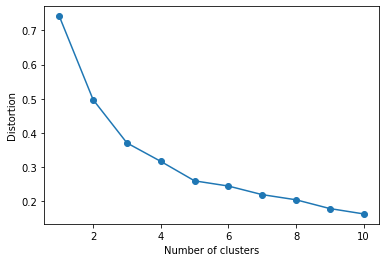

In [154]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

lisbon_cluster = lisbon_hot.drop('Parish',1)

# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(lisbon_cluster)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

As we can see, the optimal value is 5.

In [155]:
# set the number of clusters
k = 5
#run k-means clustering
kmeans = KMeans(n_clusters=k,random_state=0).fit(lisbon_cluster)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 0, 0, 3, 3, 2, 0, 0, 0])

#### Create a dataframe with all the info acquired for posterior clustering

In [156]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
lisbon_merged = lisbon

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
lisbon_merged = lisbon_merged.join(neighborhoods_venues_sorted.set_index('Parish'), on='Parish')

lisbon_merged.head() # check the last columns!

,Parish,Population,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,15 617,288,38.71173,-9.20117,4,Restaurant,Supermarket,Tennis Court,Scenic Lookout,Café,Soccer Field,Botanical Garden,Chinese Restaurant,Church,Portuguese Restaurant
1,Alcântara,13 943,"5,07",38.70457,-9.17623,0,Restaurant,Portuguese Restaurant,Coffee Shop,Italian Restaurant,Nightclub,Café,Bakery,Dessert Shop,Museum,Mediterranean Restaurant
2,Alvalade,31 813,534,38.75178,-9.14326,0,Portuguese Restaurant,Restaurant,Bar,Bakery,Italian Restaurant,Café,Burger Joint,Indian Restaurant,Supermarket,Coffee Shop
3,Areeiro,20 131,174,38.74594,-9.13459,0,Portuguese Restaurant,Bar,Ice Cream Shop,Burger Joint,Park,Plaza,Pizza Place,Brewery,Restaurant,Motorcycle Shop
4,Arroios,31 653,213,38.73456,-9.13410,3,Portuguese Restaurant,Hotel,Bakery,Indian Restaurant,Electronics Store,Plaza,Café,Supermarket,Burger Joint,Restaurant


#### Folium map with the clustered parishes

In [157]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[lat_lisb, long_lisb], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lisbon_merged['Latitude'], lisbon_merged['Longitude'], lisbon_merged['Parish'], lisbon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clusters information

### Cluster 0  (__red__)

In [212]:
cluster0=lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 0, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]].loc[lisbon_merged['Cluster Labels'] == 0, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]
cluster0=cluster0.drop(columns=['Population','Cluster Labels'])
cluster0

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Restaurant,Portuguese Restaurant,Coffee Shop,Italian Restaurant,Nightclub,Café,Bakery,Dessert Shop,Museum,Mediterranean Restaurant
2,Portuguese Restaurant,Restaurant,Bar,Bakery,Italian Restaurant,Café,Burger Joint,Indian Restaurant,Supermarket,Coffee Shop
3,Portuguese Restaurant,Bar,Ice Cream Shop,Burger Joint,Park,Plaza,Pizza Place,Brewery,Restaurant,Motorcycle Shop
7,Portuguese Restaurant,Garden,Ice Cream Shop,Café,Restaurant,Monument / Landmark,Bakery,Food Truck,Mediterranean Restaurant,Sandwich Place
8,Portuguese Restaurant,Café,Seafood Restaurant,Restaurant,Coffee Shop,Ice Cream Shop,Supermarket,Sushi Restaurant,Burger Joint,Clothing Store
9,Portuguese Restaurant,Bakery,Café,Restaurant,Steakhouse,Seafood Restaurant,Coffee Shop,Electronics Store,Bar,Furniture / Home Store
11,Portuguese Restaurant,Restaurant,Café,Soccer Stadium,Burger Joint,Coffee Shop,Clothing Store,Italian Restaurant,Supermarket,Pizza Place
12,Portuguese Restaurant,Café,Restaurant,Coffee Shop,Seafood Restaurant,Bar,Breakfast Spot,Garden,Indian Restaurant,Italian Restaurant
15,Portuguese Restaurant,Wine Bar,Restaurant,Bar,Café,Hotel,Coffee Shop,Lounge,Italian Restaurant,Seafood Restaurant
16,Portuguese Restaurant,Café,Restaurant,Bakery,Metro Station,Coffee Shop,Chinese Restaurant,Rental Car Location,Falafel Restaurant,Farm


In [217]:
def frequency_table(x):
    return pd.crosstab(index=x,  columns="count")

In [218]:
ctabs = {}
for column in cluster0:
    ctabs[column]=frequency_table(cluster0[column])

In [219]:
print(ctabs) # will print column names as strings

{'1st Most Common Venue': col_0                  count
1st Most Common Venue       
Portuguese Restaurant     11
Restaurant                 1, '2nd Most Common Venue': col_0                  count
2nd Most Common Venue       
Bakery                     1
Bar                        1
Café                       4
Garden                     1
Hotel                      1
Portuguese Restaurant      1
Restaurant                 2
Wine Bar                   1, '3rd Most Common Venue': col_0                  count
3rd Most Common Venue       
Bar                        1
Café                       3
Coffee Shop                1
Ice Cream Shop             2
Restaurant                 3
Scenic Lookout             1
Seafood Restaurant         1, '4th Most Common Venue': col_0                  count
4th Most Common Venue       
Bakery                     2
Bar                        2
Burger Joint               1
Café                       1
Coffee Shop                1
Ice Cream Shop            

### Cluster 1 (__purple__)

In [162]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 1, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]].loc[lisbon_merged['Cluster Labels'] == 1, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,22 480,1,Café,Park,Gas Station,Gym / Fitness Center,Zoo,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


In [221]:
for column in cluster0:
    ctabs[column]=frequency_table(cluster1[column])

print(ctabs) # will print column names as strings

{'1st Most Common Venue': col_0                  count
1st Most Common Venue       
Café                       1, '2nd Most Common Venue': col_0                  count
2nd Most Common Venue       
Park                       1, '3rd Most Common Venue': col_0                  count
3rd Most Common Venue       
Gas Station                1, '4th Most Common Venue': col_0                  count
4th Most Common Venue       
Gym / Fitness Center       1, '5th Most Common Venue': col_0                  count
5th Most Common Venue       
Zoo                        1, '6th Most Common Venue': col_0                  count
6th Most Common Venue       
Flea Market                1, '7th Most Common Venue': col_0                  count
7th Most Common Venue       
Fast Food Restaurant       1, '8th Most Common Venue': col_0                  count
8th Most Common Venue       
Farmers Market             1, '9th Most Common Venue': col_0                  count
9th Most Common Venue       
Farm        

### Cluster 2 (__light blue__)

In [163]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 2, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]].loc[lisbon_merged['Cluster Labels'] == 2, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,12 737,2,Restaurant,Brewery,Theater,Snack Place,Cantonese Restaurant,Music Venue,Buffet,Climbing Gym,Tapas Restaurant,Indian Restaurant
14,37 793,2,Restaurant,Portuguese Restaurant,Brewery,Art Gallery,Mediterranean Restaurant,Tapas Restaurant,Buffet,Café,Cantonese Restaurant,Motorcycle Shop


In [222]:
for column in cluster0:
    ctabs[column]=frequency_table(cluster2[column])

print(ctabs) # will print column names as strings

{'1st Most Common Venue': col_0                  count
1st Most Common Venue       
Restaurant                 2, '2nd Most Common Venue': col_0                  count
2nd Most Common Venue       
Brewery                    1
Portuguese Restaurant      1, '3rd Most Common Venue': col_0                  count
3rd Most Common Venue       
Brewery                    1
Theater                    1, '4th Most Common Venue': col_0                  count
4th Most Common Venue       
Art Gallery                1
Snack Place                1, '5th Most Common Venue': col_0                     count
5th Most Common Venue          
Cantonese Restaurant          1
Mediterranean Restaurant      1, '6th Most Common Venue': col_0                  count
6th Most Common Venue       
Music Venue                1
Tapas Restaurant           1, '7th Most Common Venue': col_0                  count
7th Most Common Venue       
Buffet                     2, '8th Most Common Venue': col_0                  cou

### Cluster 3 (__light green__)

In [223]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 3, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]].loc[lisbon_merged['Cluster Labels'] == 3, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,31 653,3,Portuguese Restaurant,Hotel,Bakery,Indian Restaurant,Electronics Store,Plaza,Café,Supermarket,Burger Joint,Restaurant
5,21 625,3,Portuguese Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Japanese Restaurant,Restaurant,Gym / Fitness Center,Pizza Place,Bookstore
10,15 460,3,Hotel,Restaurant,Portuguese Restaurant,Bakery,Hotel Bar,Gym,Scenic Lookout,Coffee Shop,Plaza,Gourmet Shop
17,21 025,3,Portuguese Restaurant,Burger Joint,Sushi Restaurant,Café,Ice Cream Shop,Hotel,Coffee Shop,Chinese Restaurant,Electronics Store,Gym / Fitness Center
18,27 967,3,Portuguese Restaurant,Hotel,Café,Indian Restaurant,Restaurant,Supermarket,Bakery,Plaza,Seafood Restaurant,Scenic Lookout
21,11 836,3,Hotel,Portuguese Restaurant,Café,Restaurant,Bakery,Hostel,Vegetarian / Vegan Restaurant,Coffee Shop,Breakfast Spot,Cocktail Bar


In [224]:
for column in cluster0:
    ctabs[column]=frequency_table(cluster3[column])

print(ctabs) # will print column names as strings

{'1st Most Common Venue': col_0                  count
1st Most Common Venue       
Hotel                      2
Portuguese Restaurant      4, '2nd Most Common Venue': col_0                  count
2nd Most Common Venue       
Burger Joint               1
Hotel                      3
Portuguese Restaurant      1
Restaurant                 1, '3rd Most Common Venue': col_0                  count
3rd Most Common Venue       
Bakery                     1
Café                       2
Italian Restaurant         1
Portuguese Restaurant      1
Sushi Restaurant           1, '4th Most Common Venue': col_0                          count
4th Most Common Venue               
Bakery                             1
Café                               1
Indian Restaurant                  2
Restaurant                         1
Vegetarian / Vegan Restaurant      1, '5th Most Common Venue': col_0                  count
5th Most Common Venue       
Bakery                     2
Electronics Store          1
Ho

### Cluster 4 (__orange__)

In [225]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 4, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]].loc[lisbon_merged['Cluster Labels'] == 4, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,15 617,4,Restaurant,Supermarket,Tennis Court,Scenic Lookout,Café,Soccer Field,Botanical Garden,Chinese Restaurant,Church,Portuguese Restaurant
13,45 605,4,Bakery,Supermarket,Café,Restaurant,Gym / Fitness Center,Portuguese Restaurant,Sushi Restaurant,BBQ Joint,Park,Plaza
22,33 043,4,Café,Restaurant,Portuguese Restaurant,Bakery,Burger Joint,Park,Electronics Store,Fast Food Restaurant,Coffee Shop,Pharmacy


In [226]:
for column in cluster0:
    ctabs[column]=frequency_table(cluster4[column])

print(ctabs) # will print column names as strings

{'1st Most Common Venue': col_0                  count
1st Most Common Venue       
Bakery                     1
Café                       1
Restaurant                 1, '2nd Most Common Venue': col_0                  count
2nd Most Common Venue       
Restaurant                 1
Supermarket                2, '3rd Most Common Venue': col_0                  count
3rd Most Common Venue       
Café                       1
Portuguese Restaurant      1
Tennis Court               1, '4th Most Common Venue': col_0                  count
4th Most Common Venue       
Bakery                     1
Restaurant                 1
Scenic Lookout             1, '5th Most Common Venue': col_0                  count
5th Most Common Venue       
Burger Joint               1
Café                       1
Gym / Fitness Center       1, '6th Most Common Venue': col_0                  count
6th Most Common Venue       
Park                       1
Portuguese Restaurant      1
Soccer Field               1, '7